<a href="https://colab.research.google.com/github/FenryrMKIII/objectDetection-yoloV3-pyTorch/blob/master/Symbol_recognition_pyTorchYolo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Optional : install some Python modules. Normally already available on colab

In [0]:
# # Install OpenCV lib
# # necessary if OPENCV=1 option is chosen when compiling darknet

# # First update
# !apt-get update
# !apt-get upgrade

# # Then install bunch of stuff necessary to install opencv (don't know why, found that on internet)
# !apt-get install build-essential
# !apt-get install cmake git libgtk2.0-dev pkg-config libavcodec-dev libavformat-dev libswscale-dev
# !apt-get install libavcodec-dev libavformat-dev libswscale-d

# # Eventually install opencv
# !apt-get install libopencv-dev


# Connect to google drive for storage

In [0]:
from google.colab import drive
drive.mount('gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at gdrive


# Check GPU capabilities

In [0]:
# check you are on GPU
# if command fails ... You are not on GPU !!

!nvidia-smi
# check cuda is installed
!cat /proc/driver/nvidia/version # verify driver version
!nvcc -V # verify cuda version

Wed Nov 20 08:08:46 2019       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 430.50       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   32C    P8    28W / 149W |      0MiB / 11441MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [0]:
# check cuda version
!/usr/local/cuda/bin/nvcc --version

# check linux version
!lsb_release -a

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2018 NVIDIA Corporation
Built on Sat_Aug_25_21:08:01_CDT_2018
Cuda compilation tools, release 10.0, V10.0.130
No LSB modules are available.
Distributor ID:	Ubuntu
Description:	Ubuntu 18.04.3 LTS
Release:	18.04
Codename:	bionic


In [0]:
# cuda is different from cuDNN
# cuDNN stands for Deep Neural Networks !
# Need to download cuDNN version applicable with installed cuda version !

!mkdir -p "/content/cudnn" 
! cp -r "/content/gdrive/My Drive/cuDNN/cudnn-10.0-linux-x64-v7.6.3.30.tgz" "/content/cudnn"

# cudnn archive was downloaded from nvidia cudnn website, requires free subscription to nvidia website
# download archive for installed cuda version (see output cell above) and choose the "linux library" link (not the linux version specific)
# to get a targz archive (not a deb !)

%cd /content/cudnn
!tar -xzvf cudnn-10.0-linux-x64-v7.6.3.30.tgz
!cp cuda/include/cudnn.h /usr/local/cuda/include # required otherwise compilation of darknet wil fail
!cp cuda/lib64/libcudnn* /usr/local/cuda/lib64 # same story !take care architecture dependent, here 64bits
!chmod a+r /usr/local/cuda/include/cudnn.h /usr/local/cuda/lib64/libcudnn* # make file property adequate

%cd /content

/content/cudnn
cuda/include/cudnn.h
cuda/NVIDIA_SLA_cuDNN_Support.txt
cuda/lib64/libcudnn.so
cuda/lib64/libcudnn.so.7
cuda/lib64/libcudnn.so.7.6.3
cuda/lib64/libcudnn_static.a
/content


# Download Yolo-V3 Pytorch implementation

In [0]:
!git clone https://github.com/eriklindernoren/PyTorch-YOLOv3
%cd PyTorch-YOLOv3
!sudo pip3 install -r requirements.txt
%cd /content/

Cloning into 'PyTorch-YOLOv3'...
remote: Enumerating objects: 724, done.
remote: Total 724 (delta 0), reused 0 (delta 0), pack-reused 724
Receiving objects: 100% (724/724), 16.17 MiB | 17.77 MiB/s, done.
Resolving deltas: 100% (422/422), done.
/content/PyTorch-YOLOv3
  Created wheel for terminaltables: filename=terminaltables-3.1.0-cp36-none-any.whl size=15354 sha256=2d481c83ad7eb4e5509812e35c970fde4f9da0e32ac5b21ecace12648a82f006
  Stored in directory: /root/.cache/pip/wheels/30/6b/50/6c75775b681fb36cdfac7f19799888ef9d8813aff9e379663e
Successfully built terminaltables
/content


# Test YOLOv3 with pre-trained weights. Either on COCO dataset  (long) or on a well-chosen test image

## Download pre-trained weights

In [0]:
# First download weights
%cd /content/PyTorch-YOLOv3/weights
!bash download_weights.sh
%cd /content/

/content/PyTorch-YOLOv3/weights
--2019-12-10 10:02:02--  https://pjreddie.com/media/files/yolov3.weights
Resolving pjreddie.com (pjreddie.com)... 128.208.4.108
Connecting to pjreddie.com (pjreddie.com)|128.208.4.108|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 248007048 (237M) [application/octet-stream]
Saving to: ‘yolov3.weights’

yolov3.weights      100%[===================>] 236.52M  77.1MB/s    in 3.1s    

2019-12-10 10:02:05 (77.1 MB/s) - ‘yolov3.weights’ saved [248007048/248007048]

--2019-12-10 10:02:05--  https://pjreddie.com/media/files/yolov3-tiny.weights
Resolving pjreddie.com (pjreddie.com)... 128.208.4.108
Connecting to pjreddie.com (pjreddie.com)|128.208.4.108|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 35434956 (34M) [application/octet-stream]
Saving to: ‘yolov3-tiny.weights’

yolov3-tiny.weights 100%[===================>]  33.79M  54.9MB/s    in 0.6s    

2019-12-10 10:02:06 (54.9 MB/s) - ‘yolov3-tiny.weights’ 

## Download COCO dataset for testing & validation. This is optional ... HUGE ! Takes some time to download

In [0]:
# Then download dataset
#%cd ../data/
#!bash get_coco_dataset.sh

/content/PyTorch-YOLOv3/data
Cloning into 'coco'...
remote: Enumerating objects: 959, done.
remote: Total 959 (delta 0), reused 0 (delta 0), pack-reused 959
Receiving objects: 100% (959/959), 11.69 MiB | 6.43 MiB/s, done.
Resolving deltas: 100% (570/570), done.
--2019-11-17 09:27:45--  https://pjreddie.com/media/files/train2014.zip
Resolving pjreddie.com (pjreddie.com)... 128.208.4.108
Connecting to pjreddie.com (pjreddie.com)|128.208.4.108|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13510435630 (13G) [application/zip]
Saving to: ‘train2014.zip’

train2014.zip       100%[===================>]  12.58G  22.7MB/s    in 10m 27s 

2019-11-17 09:38:13 (20.5 MB/s) - ‘train2014.zip’ saved [13510435630/13510435630]

--2019-11-17 09:38:13--  https://pjreddie.com/media/files/val2014.zip
Resolving pjreddie.com (pjreddie.com)... 128.208.4.108
Connecting to pjreddie.com (pjreddie.com)|128.208.4.108|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length

## Perform testing

In [0]:
# go back to yolo root directory
%cd /content/PyTorch-YOLOv3/

/content/PyTorch-YOLOv3


In [0]:
# This test is using provided test pictures
# could be performed on personal picture
# but personal picture needs to feature a class
# on which YOLOv3 has been trained (e.g. person, dog, ...)
!python3 detect.py --image_folder data/samples/

Namespace(batch_size=1, checkpoint_model=None, class_path='data/coco.names', conf_thres=0.8, image_folder='data/samples/', img_size=416, model_def='config/yolov3.cfg', n_cpu=0, nms_thres=0.4, weights_path='weights/yolov3.weights')

Performing object detection:
	+ Batch 0, Inference Time: 0:00:00.210647
	+ Batch 1, Inference Time: 0:00:00.052448
	+ Batch 2, Inference Time: 0:00:00.052335
	+ Batch 3, Inference Time: 0:00:00.050366
	+ Batch 4, Inference Time: 0:00:00.052124
	+ Batch 5, Inference Time: 0:00:00.067520
	+ Batch 6, Inference Time: 0:00:00.043082
	+ Batch 7, Inference Time: 0:00:00.043298
	+ Batch 8, Inference Time: 0:00:00.043836

Saving images:
(0) Image: 'data/samples/dog.jpg'
	+ Label: dog, Conf: 0.99335
	+ Label: bicycle, Conf: 0.99981
	+ Label: truck, Conf: 0.94229
(1) Image: 'data/samples/eagle.jpg'
	+ Label: bird, Conf: 0.99703
(2) Image: 'data/samples/field.jpg'
	+ Label: person, Conf: 0.99996
	+ Label: horse, Conf: 0.99977
	+ Label: dog, Conf: 0.99409
(3) Image: 'dat

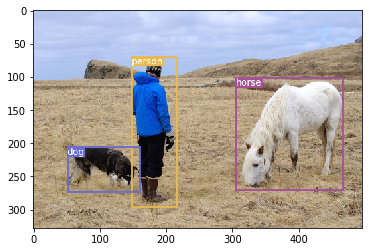

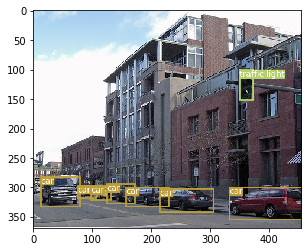

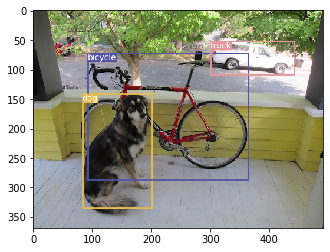

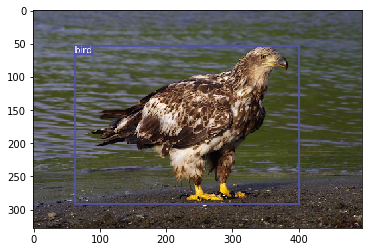

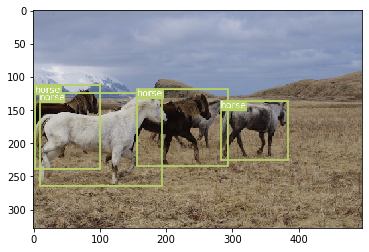

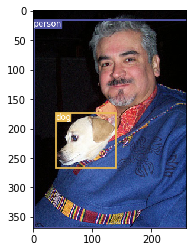

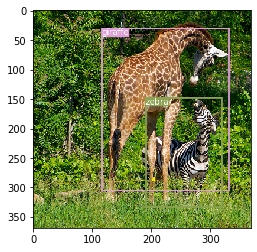

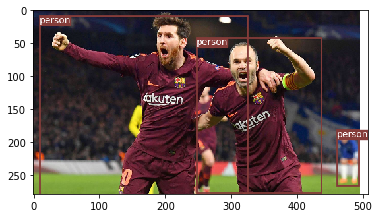

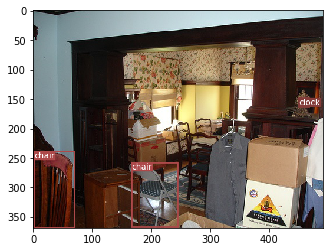

In [0]:
# Show the detection
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
for img in os.listdir(os.path.join(os.getcwd(), "output")):
  test_image = mpimg.imread(os.path.join(os.getcwd(), "output", img)) # predicted image is saved in darknet directory ... Clever way to do that ??
  plt.imshow(test_image) # creates img on curent figure
  plt.show() # actually displays the figure

# Train on COCO dataset ... If desired. Requires to have COCO dataset downloaded (HUGE)

In [0]:
%cd /content/PyTorch-YOLOv3
!python3 train.py --data_config config/coco.data  --pretrained_weights weights/darknet53.conv.74

In [0]:
# inspect some coco data to understand configuration
!cat config/coco.data
!cat config/custom.data
!cat config/coco.cfg
test_image = mpimg.imread(os.path.join(os.getcwd(), "data/coco/images/train2014", "COCO_train2014_000000291438.jpg")) 
test_image.shape

classes= 80
train=data/coco/trainvalno5k.txt
valid=data/coco/5k.txt
names=data/coco.names
backup=backup/
eval=coco
classes= 1
train=data/custom/train.txt
valid=data/custom/valid.txt
names=data/custom/classes.names
cat: config/coco.cfg: No such file or directory


(427, 640, 3)

In [0]:
!cat config/yolov3.cfg

[net]
# Testing
#batch=1
#subdivisions=1
# Training
batch=16
subdivisions=1
width=416
height=416
channels=3
momentum=0.9
decay=0.0005
angle=0
saturation = 1.5
exposure = 1.5
hue=.1

learning_rate=0.001
burn_in=1000
max_batches = 500200
policy=steps
steps=400000,450000
scales=.1,.1

[convolutional]
batch_normalize=1
filters=32
size=3
stride=1
pad=1
activation=leaky

# Downsample

[convolutional]
batch_normalize=1
filters=64
size=3
stride=2
pad=1
activation=leaky

[convolutional]
batch_normalize=1
filters=32
size=1
stride=1
pad=1
activation=leaky

[convolutional]
batch_normalize=1
filters=64
size=3
stride=1
pad=1
activation=leaky

[shortcut]
from=-3
activation=linear

# Downsample

[convolutional]
batch_normalize=1
filters=128
size=3
stride=2
pad=1
activation=leaky

[convolutional]
batch_normalize=1
filters=64
size=1
stride=1
pad=1
activation=leaky

[convolutional]
batch_normalize=1
filters=128
size=3
stride=1
pad=1
activation=leaky

[shortcut]
from=-3
activation=linear

[convolutional]


# Train on personal dataset

In [0]:
# use YOLOv3 implementation
# provided tools to define 
# training dataset configuration
!bash config/create_custom_model.sh 1 # Will create custom model 'yolov3-custom.cfg'
!mv yolov3-custom.cfg config/. 
%pycat config/yolov3-custom.cfg

In [0]:
%pycat config/yolov3-custom.cfg

In [0]:
# modify classes.names as required
# one row per class
classes = ["valve"]

with open(r"data/custom/classes.names", 'w') as f: # write will erase the content of the file
  for myClass in classes:
    f.write(myClass + "\n")

# verify written file
!cat "data/custom/classes.names"

valve


In [0]:
# create the dataset
# using a homemade script to create "overlayed"
# pictures. 
! git clone "https://github.com/FenryrMKIII/objectDetection-overlay"

Cloning into 'objectDetection-overlay'...
remote: Enumerating objects: 51, done.
remote: Counting objects: 100% (51/51), done.
remote: Compressing objects: 100% (38/38), done.
remote: Total 51 (delta 14), reused 47 (delta 10), pack-reused 0
Unpacking objects: 100% (51/51), done.


In [0]:
# in case changes are made to the repo
%cd /content/PyTorch-YOLOv3/objectDetection-overlay
!git pull
%cd /content/PyTorch-YOLOv3

/content/PyTorch-YOLOv3/objectDetection-overlay
Already up to date.
/content/PyTorch-YOLOv3


In [0]:
# create dataset with the tool
!python3 objectDetection-overlay/dataAugmentation.py

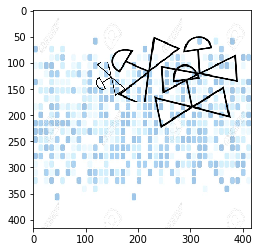

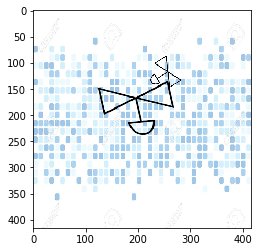

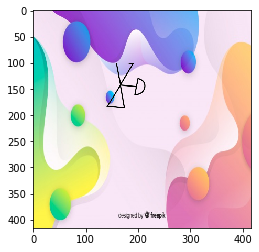

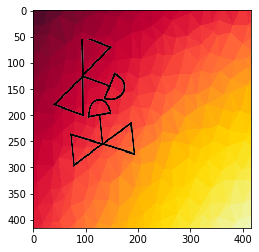

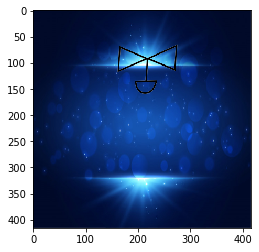

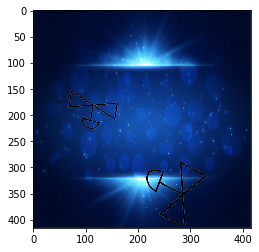

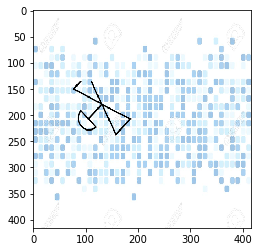

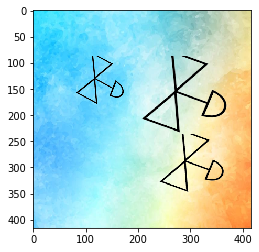

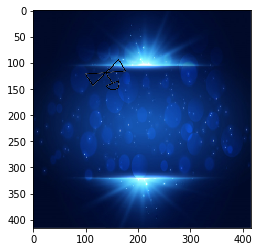

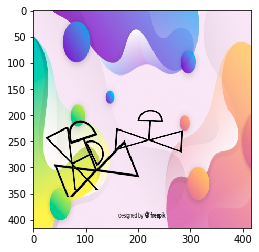

(416, 416, 4)

In [0]:
# check some generated picture
import cv2
import numpy as np
import random
picturesList = os.listdir(os.path.join(os.getcwd(), "objectDetection-overlay/trainingSet"))
picturesList = [picture for picture in picturesList if picture.endswith("png")]
somePictures = random.sample(picturesList,10)

for img in somePictures: 
  test_image = mpimg.imread(os.path.join(os.getcwd(), "objectDetection-overlay/trainingSet", img)) # predicted image is saved in darknet directory ... Clever way to do that ??
  plt.imshow(test_image) # creates img on curent figure
  plt.show() # actually displays the figure

test_image.shape

In [0]:
# optional : delete empty training file (no bbox) and associated
# training picture
import os

picturesList = os.listdir(os.path.join(os.getcwd(), "objectDetection-overlay/trainingSet"))
picturesList = [picture for picture in picturesList if picture.endswith("txt")]

for sample in picturesList:
  textFile = os.path.join(os.getcwd(), "objectDetection-overlay/trainingSet", sample)
  if os.stat(textFile).st_size == 0 :
    os.remove(textFile)
    imageFile = textFile.split(".")[0] + ".png"
    os.remove(imageFile)

In [0]:
# in case one needs to modify a file locally in Colab
# this is a way to do it "interactively"
# use line below, pop up will show code
#%pycat your/path/code.py

# copy the code in a colab cell
# and put following magic line 
# on top of the cell to write code in a file
# called code.py located in your/path/
# %%writefile your/path/code.py

# don't forget to remove old file first
# e.g. !rm your/path/oldcode.py

In [0]:
# correct utils.py to avoid unnecessary warnings
# solution found here : https://github.com/eriklindernoren/PyTorch-YOLOv3/issues/283
!rm utils/utils.py

In [0]:
%%writefile utils/utils.py
from __future__ import division
import math
import time
import tqdm
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches


def to_cpu(tensor):
    return tensor.detach().cpu()


def load_classes(path):
    """
    Loads class labels at 'path'
    """
    fp = open(path, "r")
    names = fp.read().split("\n")[:-1]
    return names


def weights_init_normal(m):
    classname = m.__class__.__name__
    if classname.find("Conv") != -1:
        torch.nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find("BatchNorm2d") != -1:
        torch.nn.init.normal_(m.weight.data, 1.0, 0.02)
        torch.nn.init.constant_(m.bias.data, 0.0)


def rescale_boxes(boxes, current_dim, original_shape):
    """ Rescales bounding boxes to the original shape """
    orig_h, orig_w = original_shape
    # The amount of padding that was added
    pad_x = max(orig_h - orig_w, 0) * (current_dim / max(original_shape))
    pad_y = max(orig_w - orig_h, 0) * (current_dim / max(original_shape))
    # Image height and width after padding is removed
    unpad_h = current_dim - pad_y
    unpad_w = current_dim - pad_x
    # Rescale bounding boxes to dimension of original image
    boxes[:, 0] = ((boxes[:, 0] - pad_x // 2) / unpad_w) * orig_w
    boxes[:, 1] = ((boxes[:, 1] - pad_y // 2) / unpad_h) * orig_h
    boxes[:, 2] = ((boxes[:, 2] - pad_x // 2) / unpad_w) * orig_w
    boxes[:, 3] = ((boxes[:, 3] - pad_y // 2) / unpad_h) * orig_h
    return boxes


def xywh2xyxy(x):
    y = x.new(x.shape)
    y[..., 0] = x[..., 0] - x[..., 2] / 2
    y[..., 1] = x[..., 1] - x[..., 3] / 2
    y[..., 2] = x[..., 0] + x[..., 2] / 2
    y[..., 3] = x[..., 1] + x[..., 3] / 2
    return y


def ap_per_class(tp, conf, pred_cls, target_cls):
    """ Compute the average precision, given the recall and precision curves.
    Source: https://github.com/rafaelpadilla/Object-Detection-Metrics.
    # Arguments
        tp:    True positives (list).
        conf:  Objectness value from 0-1 (list).
        pred_cls: Predicted object classes (list).
        target_cls: True object classes (list).
    # Returns
        The average precision as computed in py-faster-rcnn.
    """

    # Sort by objectness
    i = np.argsort(-conf)
    tp, conf, pred_cls = tp[i], conf[i], pred_cls[i]

    # Find unique classes
    unique_classes = np.unique(target_cls)

    # Create Precision-Recall curve and compute AP for each class
    ap, p, r = [], [], []
    for c in tqdm.tqdm(unique_classes, desc="Computing AP"):
        i = pred_cls == c
        n_gt = (target_cls == c).sum()  # Number of ground truth objects
        n_p = i.sum()  # Number of predicted objects

        if n_p == 0 and n_gt == 0:
            continue
        elif n_p == 0 or n_gt == 0:
            ap.append(0)
            r.append(0)
            p.append(0)
        else:
            # Accumulate FPs and TPs
            fpc = (1 - tp[i]).cumsum()
            tpc = (tp[i]).cumsum()

            # Recall
            recall_curve = tpc / (n_gt + 1e-16)
            r.append(recall_curve[-1])

            # Precision
            precision_curve = tpc / (tpc + fpc)
            p.append(precision_curve[-1])

            # AP from recall-precision curve
            ap.append(compute_ap(recall_curve, precision_curve))

    # Compute F1 score (harmonic mean of precision and recall)
    p, r, ap = np.array(p), np.array(r), np.array(ap)
    f1 = 2 * p * r / (p + r + 1e-16)

    return p, r, ap, f1, unique_classes.astype("int32")


def compute_ap(recall, precision):
    """ Compute the average precision, given the recall and precision curves.
    Code originally from https://github.com/rbgirshick/py-faster-rcnn.

    # Arguments
        recall:    The recall curve (list).
        precision: The precision curve (list).
    # Returns
        The average precision as computed in py-faster-rcnn.
    """
    # correct AP calculation
    # first append sentinel values at the end
    mrec = np.concatenate(([0.0], recall, [1.0]))
    mpre = np.concatenate(([0.0], precision, [0.0]))

    # compute the precision envelope
    for i in range(mpre.size - 1, 0, -1):
        mpre[i - 1] = np.maximum(mpre[i - 1], mpre[i])

    # to calculate area under PR curve, look for points
    # where X axis (recall) changes value
    i = np.where(mrec[1:] != mrec[:-1])[0]

    # and sum (\Delta recall) * prec
    ap = np.sum((mrec[i + 1] - mrec[i]) * mpre[i + 1])
    return ap


def get_batch_statistics(outputs, targets, iou_threshold):
    """ Compute true positives, predicted scores and predicted labels per sample """
    batch_metrics = []
    for sample_i in range(len(outputs)):

        if outputs[sample_i] is None:
            continue

        output = outputs[sample_i]
        pred_boxes = output[:, :4]
        pred_scores = output[:, 4]
        pred_labels = output[:, -1]

        true_positives = np.zeros(pred_boxes.shape[0])

        annotations = targets[targets[:, 0] == sample_i][:, 1:]
        target_labels = annotations[:, 0] if len(annotations) else []
        if len(annotations):
            detected_boxes = []
            target_boxes = annotations[:, 1:]

            for pred_i, (pred_box, pred_label) in enumerate(zip(pred_boxes, pred_labels)):

                # If targets are found break
                if len(detected_boxes) == len(annotations):
                    break

                # Ignore if label is not one of the target labels
                if pred_label not in target_labels:
                    continue

                iou, box_index = bbox_iou(pred_box.unsqueeze(0), target_boxes).max(0)
                if iou >= iou_threshold and box_index not in detected_boxes:
                    true_positives[pred_i] = 1
                    detected_boxes += [box_index]
        batch_metrics.append([true_positives, pred_scores, pred_labels])
    return batch_metrics


def bbox_wh_iou(wh1, wh2):
    wh2 = wh2.t()
    w1, h1 = wh1[0], wh1[1]
    w2, h2 = wh2[0], wh2[1]
    inter_area = torch.min(w1, w2) * torch.min(h1, h2)
    union_area = (w1 * h1 + 1e-16) + w2 * h2 - inter_area
    return inter_area / union_area


def bbox_iou(box1, box2, x1y1x2y2=True):
    """
    Returns the IoU of two bounding boxes
    """
    if not x1y1x2y2:
        # Transform from center and width to exact coordinates
        b1_x1, b1_x2 = box1[:, 0] - box1[:, 2] / 2, box1[:, 0] + box1[:, 2] / 2
        b1_y1, b1_y2 = box1[:, 1] - box1[:, 3] / 2, box1[:, 1] + box1[:, 3] / 2
        b2_x1, b2_x2 = box2[:, 0] - box2[:, 2] / 2, box2[:, 0] + box2[:, 2] / 2
        b2_y1, b2_y2 = box2[:, 1] - box2[:, 3] / 2, box2[:, 1] + box2[:, 3] / 2
    else:
        # Get the coordinates of bounding boxes
        b1_x1, b1_y1, b1_x2, b1_y2 = box1[:, 0], box1[:, 1], box1[:, 2], box1[:, 3]
        b2_x1, b2_y1, b2_x2, b2_y2 = box2[:, 0], box2[:, 1], box2[:, 2], box2[:, 3]

    # get the corrdinates of the intersection rectangle
    inter_rect_x1 = torch.max(b1_x1, b2_x1)
    inter_rect_y1 = torch.max(b1_y1, b2_y1)
    inter_rect_x2 = torch.min(b1_x2, b2_x2)
    inter_rect_y2 = torch.min(b1_y2, b2_y2)
    # Intersection area
    inter_area = torch.clamp(inter_rect_x2 - inter_rect_x1 + 1, min=0) * torch.clamp(
        inter_rect_y2 - inter_rect_y1 + 1, min=0
    )
    # Union Area
    b1_area = (b1_x2 - b1_x1 + 1) * (b1_y2 - b1_y1 + 1)
    b2_area = (b2_x2 - b2_x1 + 1) * (b2_y2 - b2_y1 + 1)

    iou = inter_area / (b1_area + b2_area - inter_area + 1e-16)

    return iou


def non_max_suppression(prediction, conf_thres=0.5, nms_thres=0.4):
    """
    Removes detections with lower object confidence score than 'conf_thres' and performs
    Non-Maximum Suppression to further filter detections.
    Returns detections with shape:
        (x1, y1, x2, y2, object_conf, class_score, class_pred)
    """

    # From (center x, center y, width, height) to (x1, y1, x2, y2)
    prediction[..., :4] = xywh2xyxy(prediction[..., :4])
    output = [None for _ in range(len(prediction))]
    for image_i, image_pred in enumerate(prediction):
        # Filter out confidence scores below threshold
        image_pred = image_pred[image_pred[:, 4] >= conf_thres]
        # If none are remaining => process next image
        if not image_pred.size(0):
            continue
        # Object confidence times class confidence
        score = image_pred[:, 4] * image_pred[:, 5:].max(1)[0]
        # Sort by it
        image_pred = image_pred[(-score).argsort()]
        class_confs, class_preds = image_pred[:, 5:].max(1, keepdim=True)
        detections = torch.cat((image_pred[:, :5], class_confs.float(), class_preds.float()), 1)
        # Perform non-maximum suppression
        keep_boxes = []
        while detections.size(0):
            large_overlap = bbox_iou(detections[0, :4].unsqueeze(0), detections[:, :4]) > nms_thres
            label_match = detections[0, -1] == detections[:, -1]
            # Indices of boxes with lower confidence scores, large IOUs and matching labels
            invalid = large_overlap & label_match
            weights = detections[invalid, 4:5]
            # Merge overlapping bboxes by order of confidence
            detections[0, :4] = (weights * detections[invalid, :4]).sum(0) / weights.sum()
            keep_boxes += [detections[0]]
            detections = detections[~invalid]
        if keep_boxes:
            output[image_i] = torch.stack(keep_boxes)

    return output


def build_targets(pred_boxes, pred_cls, target, anchors, ignore_thres):

    ByteTensor = torch.cuda.ByteTensor if pred_boxes.is_cuda else torch.ByteTensor
    BoolTensor = torch.cuda.BoolTensor if pred_boxes.is_cuda else torch.BoolTensor
    FloatTensor = torch.cuda.FloatTensor if pred_boxes.is_cuda else torch.FloatTensor

    nB = pred_boxes.size(0)
    nA = pred_boxes.size(1)
    nC = pred_cls.size(-1)
    nG = pred_boxes.size(2)

    # Output tensors
    obj_mask = BoolTensor(nB, nA, nG, nG).fill_(0)
    noobj_mask = BoolTensor(nB, nA, nG, nG).fill_(1)
    class_mask = FloatTensor(nB, nA, nG, nG).fill_(0)
    iou_scores = FloatTensor(nB, nA, nG, nG).fill_(0)
    tx = FloatTensor(nB, nA, nG, nG).fill_(0)
    ty = FloatTensor(nB, nA, nG, nG).fill_(0)
    tw = FloatTensor(nB, nA, nG, nG).fill_(0)
    th = FloatTensor(nB, nA, nG, nG).fill_(0)
    tcls = FloatTensor(nB, nA, nG, nG, nC).fill_(0)

    # Convert to position relative to box
    target_boxes = target[:, 2:6] * nG
    gxy = target_boxes[:, :2]
    gwh = target_boxes[:, 2:]
    # Get anchors with best iou
    ious = torch.stack([bbox_wh_iou(anchor, gwh) for anchor in anchors])
    best_ious, best_n = ious.max(0)
    # Separate target values
    b, target_labels = target[:, :2].long().t()
    gx, gy = gxy.t()
    gw, gh = gwh.t()
    gi, gj = gxy.long().t()
    # Set masks
    obj_mask[b, best_n, gj, gi] = 1
    noobj_mask[b, best_n, gj, gi] = 0

    # Set noobj mask to zero where iou exceeds ignore threshold
    for i, anchor_ious in enumerate(ious.t()):
        noobj_mask[b[i], anchor_ious > ignore_thres, gj[i], gi[i]] = 0

    # Coordinates
    tx[b, best_n, gj, gi] = gx - gx.floor()
    ty[b, best_n, gj, gi] = gy - gy.floor()
    # Width and height
    tw[b, best_n, gj, gi] = torch.log(gw / anchors[best_n][:, 0] + 1e-16)
    th[b, best_n, gj, gi] = torch.log(gh / anchors[best_n][:, 1] + 1e-16)
    # One-hot encoding of label
    tcls[b, best_n, gj, gi, target_labels] = 1
    # Compute label correctness and iou at best anchor
    class_mask[b, best_n, gj, gi] = (pred_cls[b, best_n, gj, gi].argmax(-1) == target_labels).float()
    iou_scores[b, best_n, gj, gi] = bbox_iou(pred_boxes[b, best_n, gj, gi], target_boxes, x1y1x2y2=False)

    tconf = obj_mask.float()
    return iou_scores, class_mask, obj_mask, noobj_mask, tx, ty, tw, th, tcls, tconf

Writing utils/utils.py


In [0]:
# first, remove dummy train data provided
# or previously created training data
imgPath = "data/custom/images/"
if os.path.exists(imgPath):
  for root, dirs, files in os.walk(imgPath, topdown=False):
    for name in files:
        os.remove(os.path.join(root, name))
    for name in dirs:
        os.rmdir(os.path.join(root, name))

labelPath = "data/custom/labels/"
if os.path.exists(labelPath):
  for root, dirs, files in os.walk(labelPath, topdown=False):
    for name in files:
        os.remove(os.path.join(root, name))
    for name in dirs:
        os.rmdir(os.path.join(root, name))

!rm data/custom/train.txt
!rm data/custom/valid.txt

# format custom data as required by the pyTorch implementation being used
from shutil import copyfile

relPathSource = r"objectDetection-overlay/trainingSet"
relPathDestImages = r"data/custom/images"
relPathDestLabels = r"data/custom/labels"

for trainSample in os.listdir(relPathSource):
  if trainSample.endswith("png") :
    copyfile(os.path.join(relPathSource, trainSample), os.path.join(relPathDestImages, trainSample))
  if trainSample.endswith("txt") :
    copyfile(os.path.join(relPathSource, trainSample), os.path.join(relPathDestLabels, trainSample))

# define which pictures are train
# and which are validation
picturePaths = []
for sample in os.listdir(relPathDestImages):
  picturePaths.append(os.path.join(relPathDestImages,sample))

import numpy as np
trainSize = round(len(picturePaths)*0.9)
picturePathsTrain = random.sample(picturePaths,trainSize)
picturePathsValid = [picture for picture in picturePaths if picture not in picturePathsTrain]
  

with open("data/custom/train.txt", 'w') as f:
  for trainSample in picturePathsTrain:
    f.write(trainSample+ "\n")

with open("data/custom/valid.txt", 'w') as f:
  for validSample in picturePathsValid:
    f.write(validSample+ "\n")

In [0]:
# remove the alpha channel
picturesList = os.listdir(os.path.join(os.getcwd(), relPathDestImages))
picturesList = [picture for picture in picturesList if picture.endswith("png")]

for img in picturesList: 
  #image = mpimg.imread(os.path.join(os.getcwd(), relPathDestImages, img))
  #image = image[:,:,:-1]
  #mpimg.imsave(os.path.join(os.getcwd(), relPathDestImages, img), image)
  imgPath = os.path.join(os.getcwd(), relPathDestImages, img)
  imageOpen = cv2.imread(imgPath) # OpenCV does not read alpha channel
  cv2.imwrite(imgPath, imageOpen)

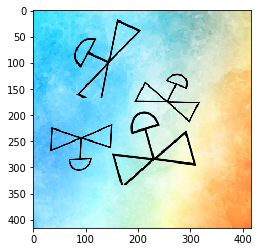

(416, 416, 3)


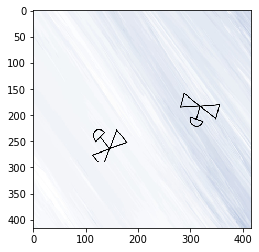

(416, 416, 3)


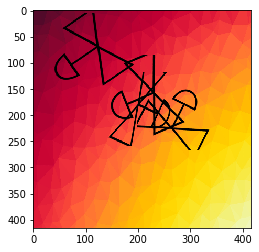

(416, 416, 3)


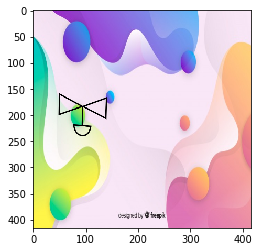

(416, 416, 3)


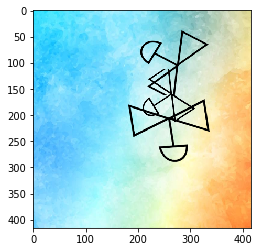

(416, 416, 3)


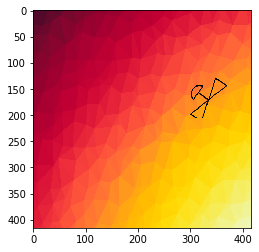

(416, 416, 3)


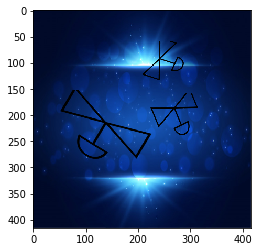

(416, 416, 3)


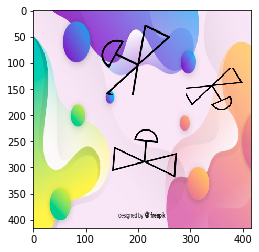

(416, 416, 3)


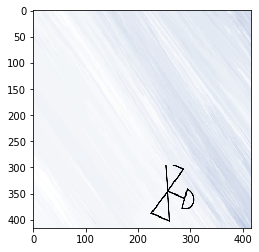

(416, 416, 3)


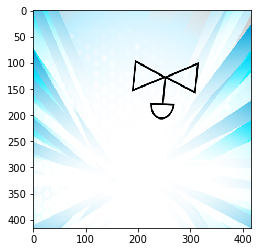

(416, 416, 3)


In [0]:
# re-check after alpha removal
somePictures = random.sample(picturesList,10)

for img in somePictures: 
  test_image = mpimg.imread(os.path.join(os.getcwd(), relPathDestImages, img)) # predicted image is saved in darknet directory ... Clever way to do that ??
  plt.imshow(test_image) # creates img on curent figure
  plt.show() # actually displays the figure
  print(test_image.shape)

In [0]:
# train on custom data
# from scratch ...
!python3 train.py --model_def config/yolov3-custom.cfg --data_config config/custom.data --pretrained_weights weights/darknet53.conv.74 --batch_size=6

# or with pretrained weights
# !python3 train.py --model_def config/yolov3-custom.cfg --data_config config/custom.data --pretrained_weights weights/darknet53.conv.74

Namespace(batch_size=6, checkpoint_interval=1, compute_map=False, data_config='config/custom.data', epochs=100, evaluation_interval=1, gradient_accumulations=2, img_size=416, model_def='config/yolov3-custom.cfg', multiscale_training=True, n_cpu=8, pretrained_weights='weights/darknet53.conv.74')



---- [Epoch 0/100, Batch 0/105] ----
+------------+--------------+--------------+--------------+
| Metrics    | YOLO Layer 0 | YOLO Layer 1 | YOLO Layer 2 |
+------------+--------------+--------------+--------------+
| grid_size  | 16           | 32           | 64           |
| loss       | 81.529266    | 76.351135    | 78.198875    |
| x          | 0.056585     | 0.075614     | 0.094503     |
| y          | 0.032751     | 0.089300     | 0.035336     |
| w          | 0.244191     | 1.503438     | 2.282132     |
| h          | 0.192345     | 0.181657     | 3.248576     |
| conf       | 80.458336    | 73.786255    | 71.781189    |
| cls        | 0.545059     | 0.714876     | 0.757138     |
| cl

In [0]:
!ls -l checkpoints/

In [0]:
!cat config/yolov3-custom.cfg


[net]
# Testing
#batch=1
#subdivisions=1
# Training
batch=16
subdivisions=1
width=416
height=416
channels=3
momentum=0.9
decay=0.0005
angle=0
saturation = 1.5
exposure = 1.5
hue=.1

learning_rate=0.001
burn_in=1000
max_batches = 500200
policy=steps
steps=400000,450000
scales=.1,.1

[convolutional]
batch_normalize=1
filters=32
size=3
stride=1
pad=1
activation=leaky

# Downsample

[convolutional]
batch_normalize=1
filters=64
size=3
stride=2
pad=1
activation=leaky

[convolutional]
batch_normalize=1
filters=32
size=1
stride=1
pad=1
activation=leaky

[convolutional]
batch_normalize=1
filters=64
size=3
stride=1
pad=1
activation=leaky

[shortcut]
from=-3
activation=linear

# Downsample

[convolutional]
batch_normalize=1
filters=128
size=3
stride=2
pad=1
activation=leaky

[convolutional]
batch_normalize=1
filters=64
size=1
stride=1
pad=1
activation=leaky

[convolutional]
batch_normalize=1
filters=128
size=3
stride=1
pad=1
activation=leaky

[shortcut]
from=-3
activation=linear

[convolutional]

In [0]:
# Creating a validation only directory
import shutil
validPath = os.path.join(os.getcwd(),"data/custom/valid/")
if os.path.exists(validPath):
  shutil.rmtree(validPath)
  os.makedirs(validPath, exist_ok = True)
else:
  os.makedirs(validPath, exist_ok = True)

with open("data/custom/valid.txt") as f :
  for imagePath in f:
    imageName = imagePath.split("/")[-1].rstrip()
    shutil.copy(os.path.realpath(imagePath.rstrip()), os.path.join(validPath, imageName))

!ls data/custom/valid

training_sample_102.png  training_sample_286.png  training_sample_454.png
training_sample_108.png  training_sample_293.png  training_sample_465.png
training_sample_119.png  training_sample_302.png  training_sample_466.png
training_sample_141.png  training_sample_306.png  training_sample_477.png
training_sample_147.png  training_sample_317.png  training_sample_513.png
training_sample_150.png  training_sample_331.png  training_sample_533.png
training_sample_154.png  training_sample_33.png   training_sample_549.png
training_sample_160.png  training_sample_342.png  training_sample_558.png
training_sample_161.png  training_sample_350.png  training_sample_566.png
training_sample_168.png  training_sample_353.png  training_sample_575.png
training_sample_169.png  training_sample_356.png  training_sample_587.png
training_sample_181.png  training_sample_372.png  training_sample_591.png
training_sample_20.png	 training_sample_384.png  training_sample_592.png
training_sample_220.png  training_sampl

In [0]:
# remove the alpha channel
picturesList = os.listdir(os.path.join(os.getcwd(), validPath))
picturesList = [picture for picture in picturesList if picture.endswith("png")]

for img in picturesList: 
  imgPath = os.path.join(os.getcwd(), validPath, img)
  imageOpen = cv2.imread(imgPath) # OpenCV does not read alpha channel
  imagePlot = mpimg.imread(os.path.join(os.getcwd(), validPath, img))
  
  #image = image[:,:,:-1]    
  #print(image.shape)       
  cv2.imwrite(imgPath, imageOpen)
  
  #image = mpimg.imread(os.path.join(os.getcwd(), validPath, img))
  #image = image[:,:,:-1]
  #print("saving in " + os.path.join(os.getcwd(), validPath, img))
  #print("image has " + str(image.shape) + " channels")
  #mpimg.imsave(os.path.join(os.getcwd(), validPath, img), image)

(416, 416, 3)
(416, 416, 3)
(416, 416, 3)
(416, 416, 3)
(416, 416, 3)
(416, 416, 3)
(416, 416, 3)
(416, 416, 3)
(416, 416, 3)
(416, 416, 3)
(416, 416, 3)
(416, 416, 3)
(416, 416, 3)
(416, 416, 3)
(416, 416, 3)
(416, 416, 3)
(416, 416, 3)
(416, 416, 3)
(416, 416, 3)
(416, 416, 3)
(416, 416, 3)
(416, 416, 3)
(416, 416, 3)
(416, 416, 3)
(416, 416, 3)
(416, 416, 3)
(416, 416, 3)
(416, 416, 3)
(416, 416, 3)
(416, 416, 3)
(416, 416, 3)
(416, 416, 3)
(416, 416, 3)
(416, 416, 3)
(416, 416, 3)
(416, 416, 3)
(416, 416, 3)
(416, 416, 3)
(416, 416, 3)
(416, 416, 3)
(416, 416, 3)
(416, 416, 3)
(416, 416, 3)
(416, 416, 3)
(416, 416, 3)
(416, 416, 3)
(416, 416, 3)
(416, 416, 3)
(416, 416, 3)
(416, 416, 3)
(416, 416, 3)
(416, 416, 3)
(416, 416, 3)
(416, 416, 3)
(416, 416, 3)
(416, 416, 3)
(416, 416, 3)
(416, 416, 3)
(416, 416, 3)
(416, 416, 3)
(416, 416, 3)
(416, 416, 3)
(416, 416, 3)
(416, 416, 3)
(416, 416, 3)
(416, 416, 3)
(416, 416, 3)
(416, 416, 3)
(416, 416, 3)
(416, 416, 3)
(416, 416, 3)
(416, 

In [0]:
for img in picturesList:
  test_image = mpimg.imread(os.path.join(os.getcwd(),validPath, img)) # predicted image is saved in darknet directory ... Clever way to do that ??
  plt.imshow(test_image) # creates img on curent figure
  plt.show() # actually displays the figure

In [0]:
outputPath = os.path.join(os.getcwd(),"output")
for picture in os.listdir(outputPath):
  os.remove(os.path.join(outputPath, picture))
!python3 detect.py --image_folder data/custom/valid --checkpoint_model checkpoints/yolov3_ckpt_99.pth --model_def config/yolov3-custom.cfg --class_path data/custom/classes.names --conf_thres 0.95 --nms_thres 0.4 --weights_path checkpoints/yolov3_ckpt_99.pth

Namespace(batch_size=1, checkpoint_model='checkpoints/yolov3_ckpt_99.pth', class_path='data/custom/classes.names', conf_thres=0.95, image_folder='data/custom/valid', img_size=416, model_def='config/yolov3-custom.cfg', n_cpu=0, nms_thres=0.4, weights_path='checkpoints/yolov3_ckpt_99.pth')

Performing object detection:
	+ Batch 0, Inference Time: 0:00:00.120884
	+ Batch 1, Inference Time: 0:00:00.090810
	+ Batch 2, Inference Time: 0:00:00.086277
	+ Batch 3, Inference Time: 0:00:00.080964
	+ Batch 4, Inference Time: 0:00:00.079103
	+ Batch 5, Inference Time: 0:00:00.075348
	+ Batch 6, Inference Time: 0:00:00.072673
	+ Batch 7, Inference Time: 0:00:00.073434
	+ Batch 8, Inference Time: 0:00:00.076827
	+ Batch 9, Inference Time: 0:00:00.075878
	+ Batch 10, Inference Time: 0:00:00.073586
	+ Batch 11, Inference Time: 0:00:00.075486
	+ Batch 12, Inference Time: 0:00:00.075297
	+ Batch 13, Inference Time: 0:00:00.076517
	+ Batch 14, Inference Time: 0:00:00.075109
	+ Batch 15, Inference Time: 0:

In [0]:
for img in os.listdir(outputPath):
  test_image = mpimg.imread(os.path.join(outputPath, img))
  plt.imshow(test_image) # creates img on curent figure
  plt.show() # actually displays the figure

In [0]:
# use a completely new picture from my drive!
!rm -rf "data/custom/validNew"
!mkdir  "data/custom/validNew"
!cp -r "/content/gdrive/My Drive/dataManagement/symbolRecognition/validationPictures/." "data/custom/validNew/."
!ls "data/custom/validNew/"

manualValve2.png  manualValve3.png


In [0]:
# remove the alpha channel
customValidPath = "data/custom/validNew"
picturesList = os.listdir(os.path.join(os.getcwd(), customValidPath))
picturesList = [picture for picture in picturesList if picture.endswith("png")]

for img in picturesList: 
  imgPath = os.path.join(os.getcwd(), customValidPath, img)
  imageOpen = cv2.imread(imgPath) # OpenCV does not read alpha channel
  imagePlot = mpimg.imread(os.path.join(os.getcwd(), customValidPath, img))

  #image = image[:,:,:-1]    
  #print(image.shape)       
  cv2.imwrite(imgPath, imageOpen)
  
  #image = mpimg.imread(os.path.join(os.getcwd(), validPath, img))
  #image = image[:,:,:-1]
  #print("saving in " + os.path.join(os.getcwd(), validPath, img))
  #print("image has " + str(image.shape) + " channels")
  #mpimg.imsave(os.path.join(os.getcwd(), validPath, img), image)

['manualValve3.png', 'manualValve2.png']


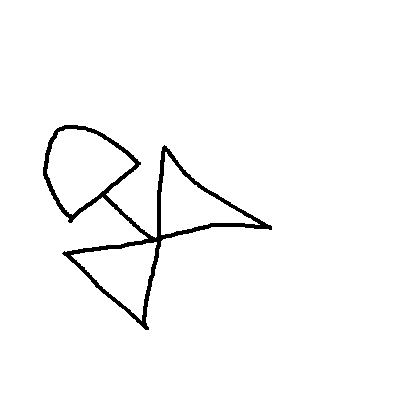

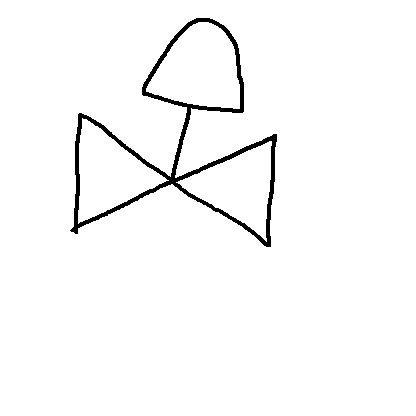

In [0]:
from google.colab.patches import cv2_imshow
print(picturesList)
for img in picturesList:
  test_image = cv2.imread(os.path.join(os.getcwd(),customValidPath, img)) # predicted image is saved in darknet directory ... Clever way to do that ??
  cv2_imshow(test_image) # creates img on curent figure


In [0]:
outputPath = os.path.join(os.getcwd(),"output")
for picture in os.listdir(outputPath):
  os.remove(os.path.join(outputPath, picture))
!python3 detect.py --image_folder data/custom/validNew --checkpoint_model checkpoints/yolov3_ckpt_99.pth --model_def config/yolov3-custom.cfg --class_path data/custom/classes.names --conf_thres 0.95 --nms_thres 0.4 --weights_path checkpoints/yolov3_ckpt_99.pth

Namespace(batch_size=1, checkpoint_model='checkpoints/yolov3_ckpt_99.pth', class_path='data/custom/classes.names', conf_thres=0.95, image_folder='data/custom/validNew', img_size=416, model_def='config/yolov3-custom.cfg', n_cpu=0, nms_thres=0.4, weights_path='checkpoints/yolov3_ckpt_99.pth')

Performing object detection:
	+ Batch 0, Inference Time: 0:00:00.111849
	+ Batch 1, Inference Time: 0:00:00.098844

Saving images:
(0) Image: 'data/custom/validNew/manualValve2.png'
	+ Label: valve, Conf: 0.99999
(1) Image: 'data/custom/validNew/manualValve3.png'


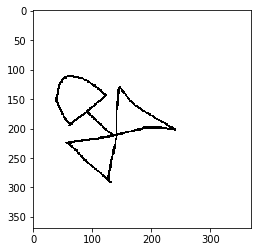

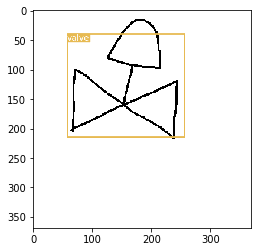

In [0]:
for img in os.listdir(outputPath):
  test_image = mpimg.imread(os.path.join(outputPath, img))
  plt.imshow(test_image) # creates img on curent figure
  plt.show() # actually displays the figure

In [0]:
# download weights
from google.colab import files
files.download(os.path.join(os.getcwd(), "checkpoints/yolov3_ckpt_99.pth"))

----------------------------------------
Exception happened during processing of request from ('::ffff:127.0.0.1', 36212, 0, 0)
Traceback (most recent call last):
  File "/usr/lib/python3.6/socketserver.py", line 320, in _handle_request_noblock
    self.process_request(request, client_address)
  File "/usr/lib/python3.6/socketserver.py", line 351, in process_request
    self.finish_request(request, client_address)
  File "/usr/lib/python3.6/socketserver.py", line 364, in finish_request
    self.RequestHandlerClass(request, client_address, self)
  File "/usr/lib/python3.6/socketserver.py", line 724, in __init__
    self.handle()
  File "/usr/lib/python3.6/http/server.py", line 418, in handle
    self.handle_one_request()
  File "/usr/lib/python3.6/http/server.py", line 406, in handle_one_request
    method()
  File "/usr/lib/python3.6/http/server.py", line 639, in do_GET
    self.copyfile(f, self.wfile)
  File "/usr/lib/python3.6/http/server.py", line 800, in copyfile
    shutil.copyfil